In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from math import sqrt
from scipy import stats
from pydataset import data
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Wrangaling the data

In [393]:
df= pd.read_csv('dnd_stats.csv')
df

,race,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma
0,dragonborn,71,195,30,14,15,12,7,13,16
1,dragonborn,75,193,30,11,11,11,13,13,17
2,dragonborn,73,252,30,14,16,11,13,10,18
3,dragonborn,75,256,30,8,19,7,10,13,16
4,dragonborn,71,205,30,8,17,14,14,10,9
...,...,...,...,...,...,...,...,...,...,...
9995,tiefling,66,146,30,13,18,17,13,15,13
9996,tiefling,69,134,30,8,14,13,6,14,20
9997,tiefling,69,194,30,4,5,16,12,12,15
9998,tiefling,70,214,30,12,16,12,15,9,16


In [394]:
df.isna().sum()

race            0
height          0
weight          0
speed           0
strength        0
dexterity       0
constitution    0
intelligence    0
wisdom          0
charisma        0
dtype: int64

In [395]:
def get_dnd():
    
    '''
    This function is used to acquire the dnd_stats.csv from the local file. If the file does not already exist,
    the function will create the file.
    ''' 
    
    if os.path.isfile('dnd_stats.csv'):
        
        return pd.read_csv('dnd_stats.csv')
    
    else:
        
        df = pd.read_csv("dnd_stats.csv")
    
        return df  
df= get_dnd()

In [396]:
df

,race,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma
0,dragonborn,71,195,30,14,15,12,7,13,16
1,dragonborn,75,193,30,11,11,11,13,13,17
2,dragonborn,73,252,30,14,16,11,13,10,18
3,dragonborn,75,256,30,8,19,7,10,13,16
4,dragonborn,71,205,30,8,17,14,14,10,9
...,...,...,...,...,...,...,...,...,...,...
9995,tiefling,66,146,30,13,18,17,13,15,13
9996,tiefling,69,134,30,8,14,13,6,14,20
9997,tiefling,69,194,30,4,5,16,12,12,15
9998,tiefling,70,214,30,12,16,12,15,9,16


In [397]:
df.dtypes

race            object
height           int64
weight           int64
speed            int64
strength         int64
dexterity        int64
constitution     int64
intelligence     int64
wisdom           int64
charisma         int64
dtype: object

In [398]:
dummy_df = pd.get_dummies(df[['race']],
                              drop_first=True)
df = pd.concat( [df, dummy_df], axis=1 )
    

In [399]:
df.rename(columns= {'race_half.elf': 'race_half_elf', 'race_half.orc': 'race_half_orc'}, inplace= True)

In [400]:
def the_split(df, stratify= None):

    """ This functions is used to split the data into 3 different datasets: train, validate(val), and test.
        It then then returns the seperate datasets and prints the shape for each of them.
    """
        
    # train/validate/test split and is reproducible due to random_state = 123
    train_validate, test= train_test_split(df, test_size= .2, random_state= 7)
    train, val= train_test_split(train_validate, test_size= .3, random_state= 7)
    
    print(f'Train shape: {train.shape}\n' )
    
    print(f'Validate shape: {val.shape}\n' )
    
    print(f'Test shape: {test.shape}')
    
    return train, val, test
train, val, test= the_split(df)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


# Exploration 

# Q1: Are gnomes likely to have a higher wisdom?

<AxesSubplot:xlabel='wisdom', ylabel='count'>

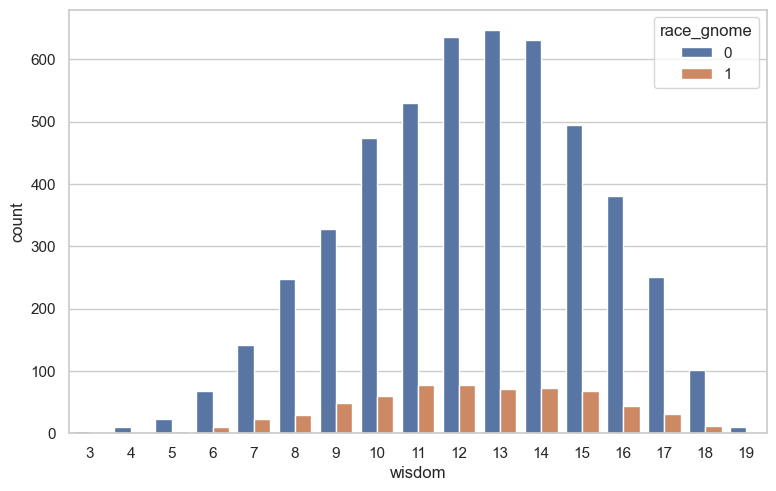

In [401]:
sns.countplot(data= train, x= 'wisdom', hue= 'race_gnome')

$H_o$: Gnome's have an equal, or less, wisdom stat compared to the other races.

$H_a$: Gnome's have a greater wisdom stat compared to the other races

In [402]:
yes_gnome= train[train.race== 'gnome'].wisdom
overall= train.wisdom.mean()

In [403]:
def run_the_t(train):
    
    yes_gnome= train[train.race== 'gnome'].wisdom
    overall= train.wisdom.mean()
    
    t, p = stats.ttest_1samp(yes_gnome, overall)

    if p/2 > alpha:
        print("We fail to reject the Null Hypothesis")
    elif t < 0:
        print("We fail to reject the Null Hypothesis")
    else:
        print("We reject the Null Hypothesis")
run_the_t(train)

We fail to reject the Null Hypothesis


# Q2: Do characters having above average stats have higher wisdom?

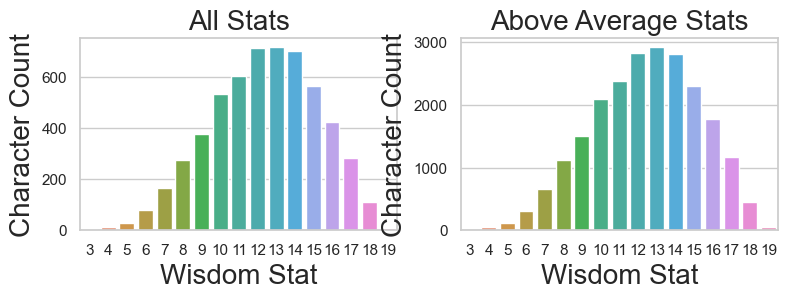

In [404]:
def plot_above(train, above_df):
    fig = plt.figure()
    ax = fig.add_subplot(221)
    sns.countplot(data= train, x= 'wisdom')

    ax.set_xlabel('Wisdom Stat', fontsize = 20)
    ax.set_ylabel('Character Count', fontsize = 20)
    ax.set_title('All Stats', fontsize = 20)

    ax = fig.add_subplot(222)
    sns.countplot(data= above_df, x= 'wisdom')
    ax.set_xlabel('Wisdom Stat', fontsize = 20)
    ax.set_ylabel('Character Count', fontsize = 20)
    ax.set_title('Above Average Stats', fontsize = 20)
    plt.show()
plot_above(train, above_df)

$H_o$: The characters who have above average stats have equal, or less, wisdom stats.

$H_a$: The characters who have above average stats have higher wisdom stats.

In [405]:
above_height= train[train.height > 60]
above_weight= train[train.weight > 145]
above_speed= train[train.speed > 28]
above_strength= train[train.strength > 13]
above_dex= train[train.dexterity > 13]
above_constitution= train[train.constitution > 13]
above_intelligence= train[train.intelligence > 13]
above_charisma= train[train.charisma > 13]

In [406]:
above_df= pd.concat([above_charisma, above_constitution, above_dex, above_height, above_intelligence,
                   above_speed, above_weight, above_strength])

In [407]:
above_mean= above_df.wisdom.mean()

In [408]:
def get_above(train):
    
    above_height= train[train.height > 60]
    above_weight= train[train.weight > 145]
    above_speed= train[train.speed > 28]
    above_strength= train[train.strength > 13]
    above_dex= train[train.dexterity > 13]
    above_constitution= train[train.constitution > 13]
    above_intelligence= train[train.intelligence > 13]
    above_charisma= train[train.charisma > 13]
    
    above_df= pd.concat([above_charisma, above_constitution, above_dex, above_height, above_intelligence,
                   above_speed, above_weight, above_strength])
    
    above_wis= above_df.wisdom
    
    overall= train.wisdom.mean()
    return above_wis, overall
above_wis, overall= get_above(train)

In [409]:
def test_above(above_wis, overall):
    
    t, p = stats.ttest_1samp(above_wis, overall)

    if p/2 > alpha:
        print("We fail to reject the Null Hypothesis")
    elif t < 0:
        print("We fail to reject the Null Hypothesis")
    else:
        print("We reject the Null Hypothesis")
test_above(above_wis, overall)

We reject the Null Hypothesis


# Q3: Do characters having both high intelligence and dexterity have greater wisdom?

In [410]:
big_smart= train[train.intelligence > 16]

In [411]:
big_brain= big_smart[big_smart.dexterity > 16]

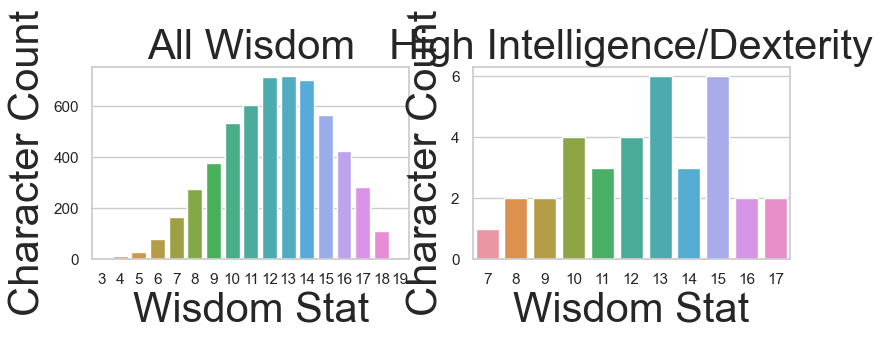

In [412]:
    fig = plt.figure()
    ax1 = fig.add_subplot(223)
    sns.countplot(data= train, x= 'wisdom')

    ax1.set_xlabel('Wisdom Stat', fontsize = 30)
    ax1.set_ylabel('Character Count', fontsize = 30)
    ax1.set_title('All Wisdom', fontsize = 30)

    ax2 = fig.add_subplot(224)
    sns.countplot(data= big_brain, x= 'wisdom')
    ax2.set_xlabel('Wisdom Stat', fontsize = 30)
    ax2.set_ylabel('Character Count', fontsize = 30)
    ax2.set_title('High Intelligence/Dexterity', fontsize = 30)
    plt.show()


# Q4: Does being a certain race mean higher wisdom?

In [413]:
dragonborn_wis= train[train.race== 'dragonborn'].wisdom.mean()
halfling_wis= train[train.race== 'halfling'].wisdom.mean()
gnome_wis= train[train.race== 'gnome'].wisdom.mean()
human_wis= train[train.race== 'human'].wisdom.mean()
tiefling_wis= train[train.race== 'tiefling'].wisdom.mean()
elf_wis= train[train.race== 'elf'].wisdom.mean()
dwarf_wis= train[train.race== 'dwarf'].wisdom.mean()
half_elf_wis= train[train.race== 'half.elf'].wisdom.mean()
half_orc= train[train.race== 'half.orc'].wisdom.mean()

In [414]:
wis_avg= pd.DataFrame({'dragonborn': dragonborn_wis,
              'halfling': halfling_wis,
              'gnome': gnome_wis,
              'human': human_wis,
              'tiefling': tiefling_wis,
              'elf': elf_wis,
              'dwarf': dwarf_wis,
              'half_elf': half_elf_wis,
              'half_orc': half_orc}, index= [0])

In [415]:
wis_mean= pd.DataFrame(train.groupby('race')['wisdom'].mean()).reset_index()

In [416]:
wis_mean

,race,wisdom
0,dragonborn,12.093702
1,dwarf,12.128165
2,elf,12.260434
3,gnome,12.221338
4,half.elf,12.624788
5,half.orc,12.123779
6,halfling,12.425868
7,human,13.252475
8,tiefling,12.366306


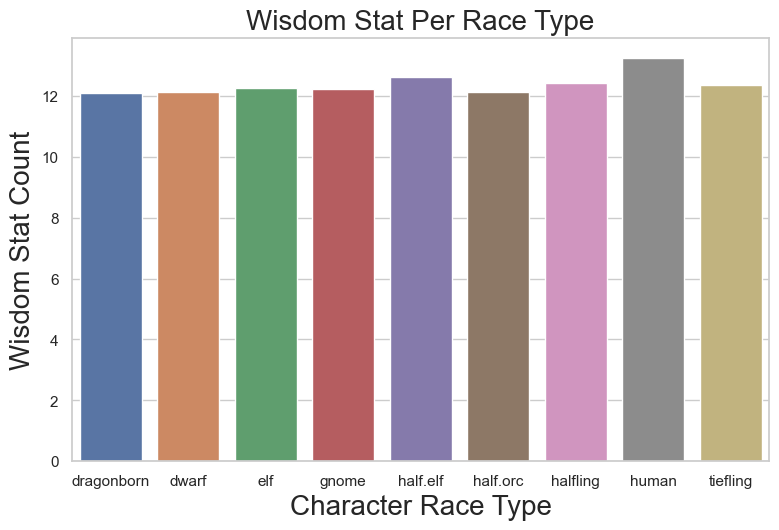

In [417]:
def wis_per_race(wis_mean):
    fig = plt.figure()
    sns.barplot(data= wis_mean, y= 'wisdom', x= 'race')
    sns.set(rc={'figure.figsize':(9.0, 5.50)})
    plt.xlabel('Character Race Type', fontsize = 20)
    plt.ylabel('Wisdom Stat Count', fontsize = 20)
    plt.title('Wisdom Stat Per Race Type', fontsize = 20)

    plt.show()
wis_per_race(wis_mean)

# Modeling 

In [418]:
def clustering(train, f1, f2):
    '''
    This function is creating unscaled and scaled clusters and adding columns to the dataset
    '''
    
    seed = 22
    
    X = train[[f1, f2]]
    
    kmeans = KMeans(n_clusters = 4, random_state= seed)
    kmeans.fit(X)
    kmeans.predict(X)

    X['unscaled_clusters'] = kmeans.predict(X)
    
    mm_scaler = MinMaxScaler()
    X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
    
    kmeans_scale = KMeans(n_clusters = 4, random_state = 22)
    kmeans_scale.fit(X[[f1, f2]])
    kmeans_scale.predict(X[[f1, f2]])
    
    X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])
    
    return X   
clusters= clustering(train, 'charisma', 'constitution')
clusters

,charisma,constitution,unscaled_clusters,scaled_clusters
4099,0.705882,0.705882,1,3
9839,0.764706,0.529412,3,0
2558,0.352941,0.588235,2,2
7552,0.352941,0.764706,2,1
8851,0.470588,0.764706,2,1
...,...,...,...,...
6397,0.588235,0.705882,2,3
3938,0.294118,0.882353,2,1
9664,0.470588,0.647059,2,1
5731,0.235294,0.882353,2,1


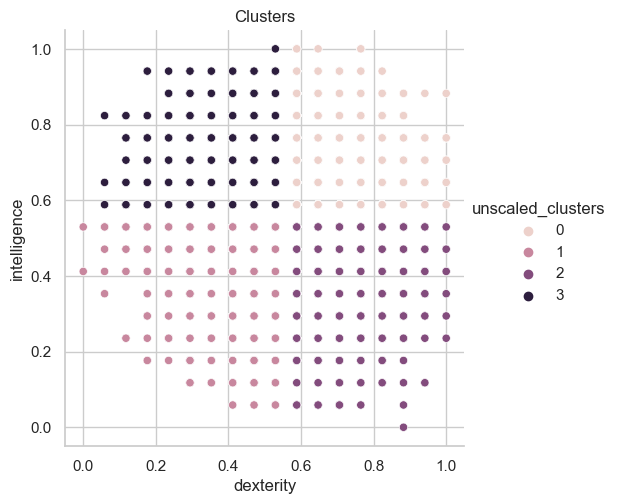

In [419]:
def cluster_relplot(df, f1, f2):
    '''
    This functions creates a relplot of the clusters
    '''
    
    sns.set(style = "whitegrid")
    
    X = clustering(df, f1, f2)
    
    sns.relplot(data = X, x = f1, y = f2, hue = 'unscaled_clusters')
    
    plt.title('Clusters')
    
    return plt.show() 
cluster_relplot(train, 'dexterity', 'intelligence')

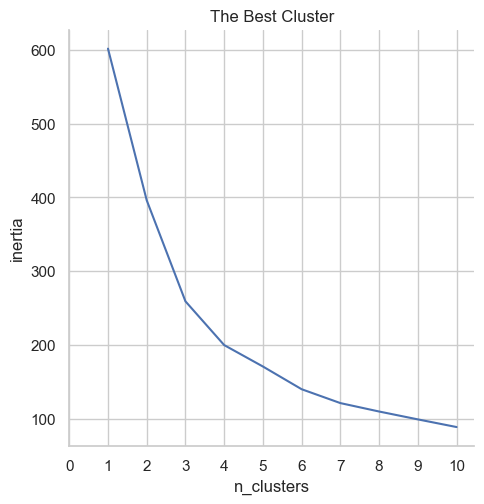

In [420]:
def best_cluster(df, f1, f2):
    '''
    This function makes a graph to show the most optimal cluster number
    '''
    
    X = clustering(df, f1, f2)
    
    inertia = []
    seed = 22 

    for n in range(1,11):

        kmeans = KMeans(n_clusters = n, random_state = seed)

        kmeans.fit(X[[f1, f2]])

        inertia.append(kmeans.inertia_)
        
        
    results_df = pd.DataFrame({'n_clusters': list(range(1,11)),
                               'inertia': inertia})   
    
    sns.set_style("whitegrid")
    sns.relplot(data = results_df, x='n_clusters', y = 'inertia', kind = 'line')
    plt.xticks(np.arange(0, 11, step=1))
    point = (3, 107) # specify the x and y values of the point to annotate
   # plt.annotate("optimal cluster", xy=point, xytext=(5, 125), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.title('The Best Cluster')
    
    return plt.show()
best_cluster(df, 'charisma', 'constitution')

In [421]:
def combined_df(df, f1, f2):
    
    X = clustering(df, f1, f2)
    
    scaled_clusters = X['scaled_clusters']
    df3 = pd.merge(df, scaled_clusters, left_index=True, right_index=True)
    
    return df3
df= combined_df(df, 'dexterity', 'intelligence')
df.drop(columns= ['race'], inplace= True)

In [423]:
df

,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma,race_dwarf,race_elf,race_gnome,race_half_elf,race_half_orc,race_halfling,race_human,race_tiefling,scaled_clusters
0,71,195,30,14,15,12,7,13,16,0,0,0,0,0,0,0,0,3
1,75,193,30,11,11,11,13,13,17,0,0,0,0,0,0,0,0,1
2,73,252,30,14,16,11,13,10,18,0,0,0,0,0,0,0,0,0
3,75,256,30,8,19,7,10,13,16,0,0,0,0,0,0,0,0,3
4,71,205,30,8,17,14,14,10,9,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,66,146,30,13,18,17,13,15,13,0,0,0,0,0,0,0,1,0
9996,69,134,30,8,14,13,6,14,20,0,0,0,0,0,0,0,1,3
9997,69,194,30,4,5,16,12,12,15,0,0,0,0,0,0,0,1,2
9998,70,214,30,12,16,12,15,9,16,0,0,0,0,0,0,0,1,0


In [424]:
train, val, test= the_split(df)

Train shape: (5600, 18)

Validate shape: (2400, 18)

Test shape: (2000, 18)


In [428]:
train_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)
val_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)
test_scaled.drop(columns= ['scaled_clusters_y'], inplace= True)

In [435]:
train_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)
val_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)
test_scaled.rename(columns= {'scaled_clusters_x': 'scaled_clusters'}, inplace= True)

In [387]:
def mvp_scaled_data(train, val, test, return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    columns_scale = train.iloc[:, :11]
    columns_to_scale = columns_scale.columns
    
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    val_scaled = val.copy()
    test_scaled = test.copy()
    #     make the thing
    mms = MinMaxScaler()
    #     fit the thing
    mms.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(mms.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    val_scaled[columns_to_scale] = pd.DataFrame(mms.transform(val[columns_to_scale]), 
                                                     columns=val[columns_to_scale].columns.values).set_index([val.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(mms.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, val_scaled, test_scaled
train_scaled, val_scaled, test_scaled= mvp_scaled_data(train, val, test)
train_scaled

,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma,race_dwarf,race_elf,race_gnome,race_half_elf,race_half_orc,race_halfling,race_human,race_tiefling,scaled_clusters_x,scaled_clusters_y
4099,0.142857,0.000000,0.0,0.352941,0.470588,0.705882,0.117647,0.8125,0.705882,0.0,0.0,1,0,0,0,0,0,2,2
9839,0.530612,0.280130,1.0,0.705882,0.529412,0.529412,0.588235,0.3750,0.764706,0.0,0.0,0,0,0,0,0,1,1,1
2558,0.551020,0.273616,1.0,0.470588,0.705882,0.588235,0.647059,0.7500,0.352941,0.0,1.0,0,0,0,0,0,0,0,0
7552,0.061224,0.000000,0.0,0.529412,0.588235,0.764706,0.470588,0.7500,0.352941,0.0,0.0,0,0,0,1,0,0,3,3
8851,0.795918,0.449511,1.0,0.647059,0.294118,0.764706,0.705882,0.6875,0.470588,0.0,0.0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397,0.755102,0.456026,1.0,0.764706,0.470588,0.705882,0.411765,0.6875,0.588235,0.0,0.0,0,0,1,0,0,0,2,2
3938,0.183673,0.000000,0.0,0.352941,0.647059,0.882353,0.647059,0.2500,0.294118,0.0,0.0,1,0,0,0,0,0,0,0
9664,0.591837,0.322476,1.0,0.647059,0.764706,0.647059,0.705882,0.5625,0.470588,0.0,0.0,0,0,0,0,0,1,0,0
5731,0.816327,0.631922,1.0,0.647059,0.470588,0.882353,0.823529,0.3750,0.235294,0.0,0.0,0,0,1,0,0,0,1,1


In [434]:
train_scaled.head()

,height,weight,speed,strength,dexterity,constitution,intelligence,wisdom,charisma,race_dwarf,race_elf,race_gnome,race_half_elf,race_half_orc,race_halfling,race_human,race_tiefling,scaled_clusters_x
4099,0.142857,0.000000,0.0,0.352941,0.470588,0.705882,0.117647,0.8125,0.705882,0.0,0.0,1,0,0,0,0,0,2
9839,0.530612,0.280130,1.0,0.705882,0.529412,0.529412,0.588235,0.3750,0.764706,0.0,0.0,0,0,0,0,0,1,1
2558,0.551020,0.273616,1.0,0.470588,0.705882,0.588235,0.647059,0.7500,0.352941,0.0,1.0,0,0,0,0,0,0,0
7552,0.061224,0.000000,0.0,0.529412,0.588235,0.764706,0.470588,0.7500,0.352941,0.0,0.0,0,0,0,1,0,0,3
8851,0.795918,0.449511,1.0,0.647059,0.294118,0.764706,0.705882,0.6875,0.470588,0.0,0.0,0,0,0,0,1,0,1


In [442]:
def splitting_subsets(train, train_scaled, val_scaled, test_scaled, target):
    '''
    This function splits our train, validate, and test scaled datasets into X/y train,
    validate, and test subsets
    '''
    
    
    X_train = train_scaled.drop(columns = [target])
    X_train = pd.get_dummies(X_train, columns = ['scaled_clusters'])
    y_train = train_scaled[target]


    X_val = val_scaled.drop(columns = [target])
    X_val = pd.get_dummies(X_val, columns = ['scaled_clusters'])
    y_val = val_scaled[target]


    X_test = test_scaled.drop(columns = [target])
    X_test = pd.get_dummies(X_test, columns = ['scaled_clusters'])
    y_test = test_scaled[target]

    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_validate, y_val, X_test, y_test= splitting_subsets(train, train_scaled, val_scaled, test_scaled, target= 'wisdom')
X_train

,height,weight,speed,strength,dexterity,constitution,intelligence,charisma,race_dwarf,race_elf,race_gnome,race_half_elf,race_half_orc,race_halfling,race_human,race_tiefling,scaled_clusters_0,scaled_clusters_1,scaled_clusters_2,scaled_clusters_3
4099,0.142857,0.000000,0.0,0.352941,0.470588,0.705882,0.117647,0.705882,0.0,0.0,1,0,0,0,0,0,0,0,1,0
9839,0.530612,0.280130,1.0,0.705882,0.529412,0.529412,0.588235,0.764706,0.0,0.0,0,0,0,0,0,1,0,1,0,0
2558,0.551020,0.273616,1.0,0.470588,0.705882,0.588235,0.647059,0.352941,0.0,1.0,0,0,0,0,0,0,1,0,0,0
7552,0.061224,0.000000,0.0,0.529412,0.588235,0.764706,0.470588,0.352941,0.0,0.0,0,0,0,1,0,0,0,0,0,1
8851,0.795918,0.449511,1.0,0.647059,0.294118,0.764706,0.705882,0.470588,0.0,0.0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397,0.755102,0.456026,1.0,0.764706,0.470588,0.705882,0.411765,0.588235,0.0,0.0,0,0,1,0,0,0,0,0,1,0
3938,0.183673,0.000000,0.0,0.352941,0.647059,0.882353,0.647059,0.294118,0.0,0.0,1,0,0,0,0,0,1,0,0,0
9664,0.591837,0.322476,1.0,0.647059,0.764706,0.647059,0.705882,0.470588,0.0,0.0,0,0,0,0,0,1,1,0,0,0
5731,0.816327,0.631922,1.0,0.647059,0.470588,0.882353,0.823529,0.235294,0.0,0.0,0,0,1,0,0,0,0,1,0,0


In [446]:
def baseline(y_train):
    '''
    This function takes in y_train to calculate the baseline rmse
    '''
    
    preds_df = pd.DataFrame({'actual': y_train})
    
    preds_df['baseline'] = y_train.mean()
    
    baseline_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.baseline))

    return baseline_rmse
baseline(y_train)

0.17895299322247404